In [1]:
import pandas as pd 
import numpy as np
import math
import tensorflow as tf
print(pd.__version__)
import random
import matplotlib.pyplot as plt
from multiprocessing.pool import Pool

1.2.0


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K
from keras import optimizers
from keras import models
from keras import layers
from tensorflow import keras 

In [3]:
model_regr = keras.models.load_model('../models/regression/large_mse.h5')
model_class = keras.models.load_model('../models/classifier/with-dropout-100.h5')

In [4]:
def gen_electron(dimx, dimy, p1):
    x1 = random.uniform(dimx[0], dimx[1])
    x2 = random.uniform(dimy[0], dimy[1])
    return np.array([p1, 0, 0, x1, x2])

In [5]:
def gen_photon(dimx, dimy, modulus):
    x1 = random.uniform(dimx[0], dimx[1])
    x2 = random.uniform(dimy[0], dimy[1])
    costheta = random.uniform(-1, 1)
    cosphi = random.random()
    proj_xy = cosphi*modulus
    return np.array([proj_xy*costheta, proj_xy*np.sqrt(1-costheta**2), modulus*np.sqrt(1-cosphi**2), x1, x2])

In [18]:
x = 2
y = 2
p_e = 0.1
p_pho = 0.025  
nodes_x = 2
nodes_y = 2
dx = x/nodes_x
dy = y/nodes_y
per_node = 10000
threshold = 0.5

In [22]:
def node_operation(node_x, node_y, dx, dy, threshold, p_e, p_pho, per_node):
    print("x: {}, y: {}".format(node_x, node_y))
    photon_final = []
    lim_x_min = dx* node_x
    lim_x_max = (dx+1)*node_x 
    lim_y_min = dy* node_y
    lim_y_max = (dy+1)*node_y
    for n in range(per_node):
        electron = gen_electron([lim_x_min, lim_x_max], [lim_y_min, lim_y_max], p_e)
        photon = gen_photon([lim_x_min, lim_x_max], [lim_y_min, lim_y_max], p_pho)
        class_x = np.array([[electron[0], electron[1], electron[2],
                      photon[0], photon[1], photon[2],
                      electron[3], electron[4],
                      photon[3], photon[4]]])
        classification = model_class.predict(np.stack(class_x))
        if classification >= threshold:
            regr_x = np.array([class_x[0,:6]])
            regr_data = model_regr.predict(regr_x)
            photon_final.append(np.linalg.norm(regr_data[0]))
    return np.array(photon_final)


In [23]:
args = [(x, y, dx, dy, threshold, p_e, p_pho, per_node) for x in range(nodes_x) for y in range(nodes_y)]
results = np.array([])
for arg in args:
    results = np.concatenate((results, node_operation(*arg)))

x: 0, y: 0
x: 0, y: 1
x: 1, y: 0
x: 1, y: 1


In [24]:
results

array([0.02619224, 0.02589246, 0.02585292, ..., 0.02630499, 0.02644521,
       0.02589151])

In [25]:
np.array(results)

array([0.02619224, 0.02589246, 0.02585292, ..., 0.02630499, 0.02644521,
       0.02589151])

In [26]:
def energy_spectrum(energy_array, bins):
    energy_array = np.array(energy_array)
    plt.hist(energy_array, bins)
    plt.yscale("log")
    plt.show()

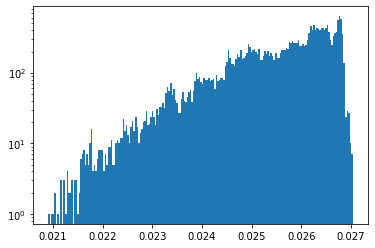

In [27]:
energy_spectrum(results, 200)

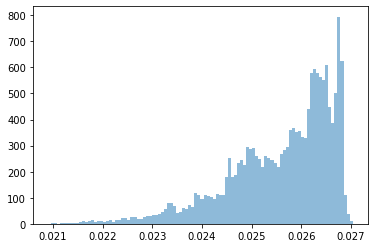

In [28]:
plt.hist(results, 100, alpha=0.5, label='Energy Spectrum Photons', density = True)
#plt.xlabel('Photon Momentum')
#plt.ylabel('count')
#plt.legend(loc='upper right')
#plt.xlim((0, 0.25))
#plt.ylim((0, 1000))
plt.show()